# Generate dogs!
Uses GAN, customized variant of: <br>
Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks
(Alec Radford, Luke Metz, Soumith Chintala)

In [ ]:
#Other variants to try:
#-add label info to encoder input 
#-try variational GAN
#possibly more augments: tf.image.random_crop, tf.image.crop_central,

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from datetime import datetime
import PIL
from keras import layers
from keras import Sequential
from keras.layers import Conv2DTranspose, Conv2D, BatchNormalization, ReLU, LeakyReLU, Dropout, Dense, Activation, Input, Reshape, Flatten
import keras
import time
from IPython import display

In [40]:
output_activation = 'tanh'
load_checkpoint = False
data_dir='/home/evan/Datasets/tensorflow'
buffer_size = 3200
batch_size = 32
num_epochs = 5
image_size = (128,128)
channels = 3
latent_size = 120 #i.e. size of generator input
filters_gen = 64 #filters in second to last generator conv layer 
filters_dis = 64 #filters in first discriminator conv layer
lr = 0.0002
beta1 = 0.5

if output_activation == 'sigmoid':
    def normalize(x):
        return x / 255. #0 to 1 
    def denormalize(x):
        return x * 255.
if output_activation == 'tanh':
    def normalize(x):
        return (x - 127.5) / 127.5  #-1 to 1 
    def denormalize(x):
        return (x * 127.5) + 127.5 

try:
    train_dataset = tfds.load('stanford_dogs', as_supervised=False, split='train', data_dir=data_dir, download=False)
except e:
    print(e)
    train_dataset = tfds.load('stanford_dogs', as_supervised=False, split='train', data_dir=data_dir, download=True)

def transform(x):
    #********TODO: there are m ultiple bbox, only 1 image, dataset comes unbatched, crop_and_resize takes batches, crop_to_bbox takes single image
    #possible to crop multiple and concat, or only take 1
    boxes = x['objects']['bbox']
    x = x['image']
    print(boxes.shape)
    x = tf.cast(x, tf.float32)
    if random.uniform(0.,1.) > 0.:
        x = tf.image.crop_and_resize(x, boxes, box_indices=np.arange(batch_size), crop_size=image_size, method='bilinear') #operates on batches
    else:
        x = tf.image.resize(x, image_size, method='bicubic')
    x = normalize(x)
    x = tf.image.random_flip_left_right(x) 
    # x = tf.image.random_brightness(x, .2)
    return x

# Lanczos kernel with radius 5. Very-high-quality filter but may have stronger ringing
train_dataset = train_dataset.map(lambda x: transform(x))\
                             .shuffle(buffer_size)\
                             .batch(batch_size)\
                             .prefetch(tf.data.experimental.AUTOTUNE)


(None, 4)


ValueError: in user code:

    /tmp/ipykernel_19389/2971931594.py:47 None  *
        lambda x: transform(x)
    /tmp/ipykernel_19389/3369268725.py:38 transform  *
        x = tf.image.crop_and_resize(x, boxes, box_indices=np.arange(batch_size), crop_size=image_size, method='bilinear') #operates on batches
    /home/evan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /home/evan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/ops/image_ops_impl.py:4747 crop_and_resize_v2
        return gen_image_ops.crop_and_resize(image, boxes, box_indices, crop_size,
    /home/evan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/ops/gen_image_ops.py:499 crop_and_resize
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/evan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /home/evan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /home/evan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:3561 _create_op_internal
        ret = Operation(
    /home/evan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /home/evan/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Shape must be rank 4 but is rank 3 for '{{node CropAndResize}} = CropAndResize[T=DT_FLOAT, extrapolation_value=0, method="bilinear"](Cast, args_3, CropAndResize/box_ind, CropAndResize/crop_size)' with input shapes: [?,?,3], [?,4], [32], [2].


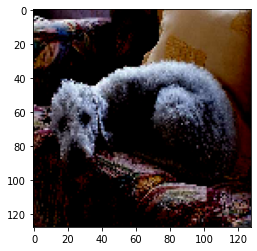

In [14]:
plt.imshow((next(train_dataset.as_numpy_iterator())[0]))

In [ ]:
w_init = tf.random_normal_initializer(stddev=0.02)
gamma_init = tf.random_normal_initializer(1., 0.02)

def make_generator_model():
    model = keras.Sequential([
            # input is Z, going into a convolution
            Input((latent_size)),
            Dense(np.prod([image_size[0]/16, image_size[1]/16, 3]), kernel_initializer=w_init),
            Reshape((image_size[0]//16,image_size[0]//16)+(3,)),
            Conv2DTranspose(filters = filters_gen * 8, kernel_size=5, strides=2,
                            padding='same',use_bias=False, kernel_initializer=w_init),
            BatchNormalization(axis=-1,gamma_initializer=gamma_init, momentum=0.9),
            ReLU(),
            Conv2DTranspose(filters = filters_gen * 4, kernel_size=5, strides=2,
                            padding='same',use_bias=False, kernel_initializer=w_init),
            BatchNormalization(axis=-1,gamma_initializer=gamma_init, momentum=0.9),
            ReLU(),
            Conv2DTranspose(filters = filters_gen * 2, kernel_size=5, strides=2,
                            padding='same',use_bias=False, kernel_initializer=w_init),
            BatchNormalization(axis=-1,gamma_initializer=gamma_init, momentum=0.9),
            ReLU(),
            Conv2DTranspose(filters = filters_gen, kernel_size=5, strides=2,
                            padding='same',use_bias=False, kernel_initializer=w_init),
            BatchNormalization(axis=-1,gamma_initializer=gamma_init, momentum=0.9),
            ReLU(),
            Conv2DTranspose(channels, 4, 1,padding='same',use_bias=False),
            Activation(output_activation)
    ])
    return model

generator = make_generator_model()
generator.summary()
noise = tf.random.normal([1, latent_size])
generated_image = generator(noise, training=False).numpy()
print(generated_image.shape)
print(generated_image.sum())
plt.imshow(generated_image[0, :, :, :])

In [ ]:
def make_discriminator_model():
    model = Sequential([
        Conv2D(filters_dis,kernel_size=5, strides=2, padding='same',
               use_bias=False, input_shape=(64,64,3),
               kernel_initializer=w_init),
        BatchNormalization(axis=-1,gamma_initializer=gamma_init, momentum=0.9),
        LeakyReLU(0.2),
        Conv2D(filters_dis*2,kernel_size=5, strides=2, padding='same',
               use_bias=False, input_shape=(64,64,3),
               kernel_initializer=w_init),
        BatchNormalization(axis=-1,gamma_initializer=gamma_init, momentum=0.9),
        LeakyReLU(0.2),
        Conv2D(filters_dis*4,kernel_size=5, strides=2, padding='same',
               use_bias=False, input_shape=(64,64,3),
               kernel_initializer=w_init),
        BatchNormalization(axis=-1,gamma_initializer=gamma_init, momentum=0.9),
        LeakyReLU(0.2),
        Conv2D(filters_dis*8,kernel_size=5, strides=2, padding='same',
               use_bias=False, input_shape=(64,64,3),
               kernel_initializer=w_init),
        BatchNormalization(axis=-1,gamma_initializer=gamma_init, momentum=0.9),
        LeakyReLU(0.2),
        Flatten(),
        Dense(1),
        Activation(output_activation)
    ])
    return model

discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta1)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta1)

In [ ]:
checkpoint_dir = './training_checkpoints' + datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 200
noise_dim = 120
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.fuchannelstion`
# This annotation causes the fuchannelstion to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
if load_checkpoint:
    ckpt = tf.train.Checkpoint(
        generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator
    )
    manager = tf.train.CheckpointManager(ckpt, './training_checkpoints/', max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inferechannelse mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
train(train_dataset, EPOCHS)
